After using `experiment.ipynb` to create the learned models, use this to plot decision boundaries.

In [1]:
import numpy as np
from scipy import stats
from datetime import datetime
import pandas as pd
from matplotlib import pyplot as plt 
import matplotlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Add
import os

# Set directory to be the same as experiment.ipynb
# If export_figure=True, will also put figures into this directory.
bp = '/home/ubuntu/'
export_figure = True

# Set model parameters here based on which experiment you are looking at

rcn = 0.1
margin = 0.5
x_loc = 3.0
width = 1000
use_bias_inner = False
use_bias_outer = False
trainable_outer = False
activation = 'leaky'

# Use the keyword from experiment.ipynb for files to filter h5 models
experiment = 'onelayerfc' + str(int(width)) + '_rcn' + str(rcn)

Create the dataset $\mathcal{D}_{\gamma_0, b}$.

In [2]:
def prep_dataset(n_train, x_loc = 3.0, margin = 0.0, rcn = 0.0, boundary_factor = 1.75, seed = 123):
    # Set seed for data
    np.random.seed(seed)
    n_per_class = int(n_train // 2)
    # Create two clusters of data, centered at (+/- x_loc, 0)
    clust1 = np.random.normal(loc = (-1*x_loc, 0), size = (n_per_class, 2))
    clust2 = np.random.normal(loc = (x_loc, 0), size = (n_per_class, 2))
    
    # Introduce RCN and deterministic label noise.
    # Ensure that rcn fraction of |x|>b have labels flipped,
    # and that 100% of labels with |x|<b have been flipped.
    
    # Initially make rcn fraction of labels with x>0 have label 0,
    # and rcn fraction of labels with x<0 have label 1.
    flip = int(n_per_class * rcn)
    class1 = np.array([0.0] * (n_per_class - flip) + [1] * flip)
    class2 = np.array([1] * (n_per_class - flip) + [0] * flip)
    
    # Then deterministically set label to 0 if 0<x<b and label to 1 if -b<x<0
    class1[(clust1[:,0] <= boundary_factor) & (clust1[:,0] >= 0)] = 0
    class2[(clust2[:,0] <= boundary_factor) & (clust2[:,0] >= 0)] = 0
    class1[(clust1[:,0] >= -1*boundary_factor) & (clust1[:,0] <= 0)] = 1
    class2[(clust2[:,0] >= -1*boundary_factor) & (clust2[:,0] <= 0)] = 1
    
    # Create pandas df for easy plotting later on.
    data = pd.DataFrame.from_dict({
        'x': np.concatenate([clust1[:,0], clust2[:,0]], axis = 0),
        'y': np.concatenate([clust1[:,1], clust2[:,1]], axis = 0),
        'group': np.concatenate([class1, class2])})
    data['group'] = data['group'].astype('category')
    
    # If using a margin, remove all data with |x| < margin.
    if margin > 0:
        data = data[np.abs(data.x) > margin]
    
    # Extract numpy arrays of data to be used for creating tf dataset.
    features = np.array((data.x, data.y)).T
    response = np.array(data.group)
    return data, features, response

Define a function to convert $\mathsf{OPT}_{\mathsf{lin}}$ value to boundary factor value.

In [3]:
def b_from_error(error, margin = 0.5, rcn = 0.1):
    Z = stats.norm.cdf(3 - margin)
    return 3 - stats.norm.ppf( (1 - error)*Z/(1 - rcn))

Prepare the model structure.  Be sure this is the exact same as the learner structure used in `experiment.ipynb`.

In [4]:
# Create outer layer initializer of all +/- constant.
class UniformPlusMinusConstant(keras.initializers.Initializer):
    def __init__(self, const, seed = None):
        self.const = tf.constant(const, dtype = keras.backend.floatx())
        self.seed = seed
    def __call__(self, shape, dtype=None):
        k = int(shape[0] / 2) 
        if shape[0] % 2 == 0:
            return self.const * tf.concat([tf.constant(1.0, shape = (k,1)), tf.constant(-1.0, shape = (k,1))], axis = 0)
        else:
            return self.const * tf.concat([tf.constant(1.0, shape = (k+1,1)), tf.constant(-1.0, shape = (k,1))], axis = 0)
    def get_config(self):  # To support serialization
        return {'const': self.const}

# Create one-hidden-layer neural network learner.
def one_hlayer_learner(d, # Input dimension
                       m, # Width of network
                       activation = 'leaky', # Either leaky, relu, tanh, sigmoid, elu 
                       init_sd = 0.001, # Initialization SD for std normal initializer
                       use_bias_inner = False,
                       use_bias_outer = False,
                       trainable_outer = False, 
                       seed = 123): # Seed for random initialization of weights
    inputs = Input(shape = (d,), name = 'input')
    if activation == 'leaky':
        x = Dense(m, 
                  kernel_initializer = keras.initializers.RandomNormal(stddev = init_sd, seed = seed),
                  activation = None, 
                  use_bias = use_bias_inner)(inputs)
        x = LeakyReLU(alpha = 0.1)(x)
    else:
        x = Dense(m, 
                  kernel_initializer = keras.initializers.RandomNormal(stddev = init_sd, seed = seed),
                  activation = activation, 
                  use_bias = use_bias_inner)(inputs)
    output = Dense(1, 
                   kernel_initializer = UniformPlusMinusConstant(1.0/np.sqrt(m), seed),
                   activation = 'linear', 
                   use_bias = use_bias_outer,
                   trainable = trainable_outer)(x)
    return keras.Model(inputs = inputs, outputs = output)



# Utility to load model weights
def load_model(model, weight_path):
    model.load_weights(weight_path)
    return model

In [5]:
# To allow different markers for different categories, need
# to create a new version of scatter.
def mscatter(x,y,ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

Utility for generating predictions on a grid for a given model.

In [6]:
def get_predictions(model, xmin, xmax, ymin, ymax, grid_points = 250):
    # Define region of interest by data limits
    x_span = np.linspace(xmin, xmax, grid_points)
    y_span = np.linspace(ymin, ymax, grid_points)
    xx, yy = np.meshgrid(x_span, y_span)
    # Make predictions across region of interest
    labels = model.predict(np.c_[xx.ravel(), yy.ravel()])
    z = labels.reshape(xx.shape)
    return xx, yy, labels, z

Create the contour plots for different values of $\mathsf{OPT}_{\mathsf{lin}}$ for different random initializations of the first layer weights.

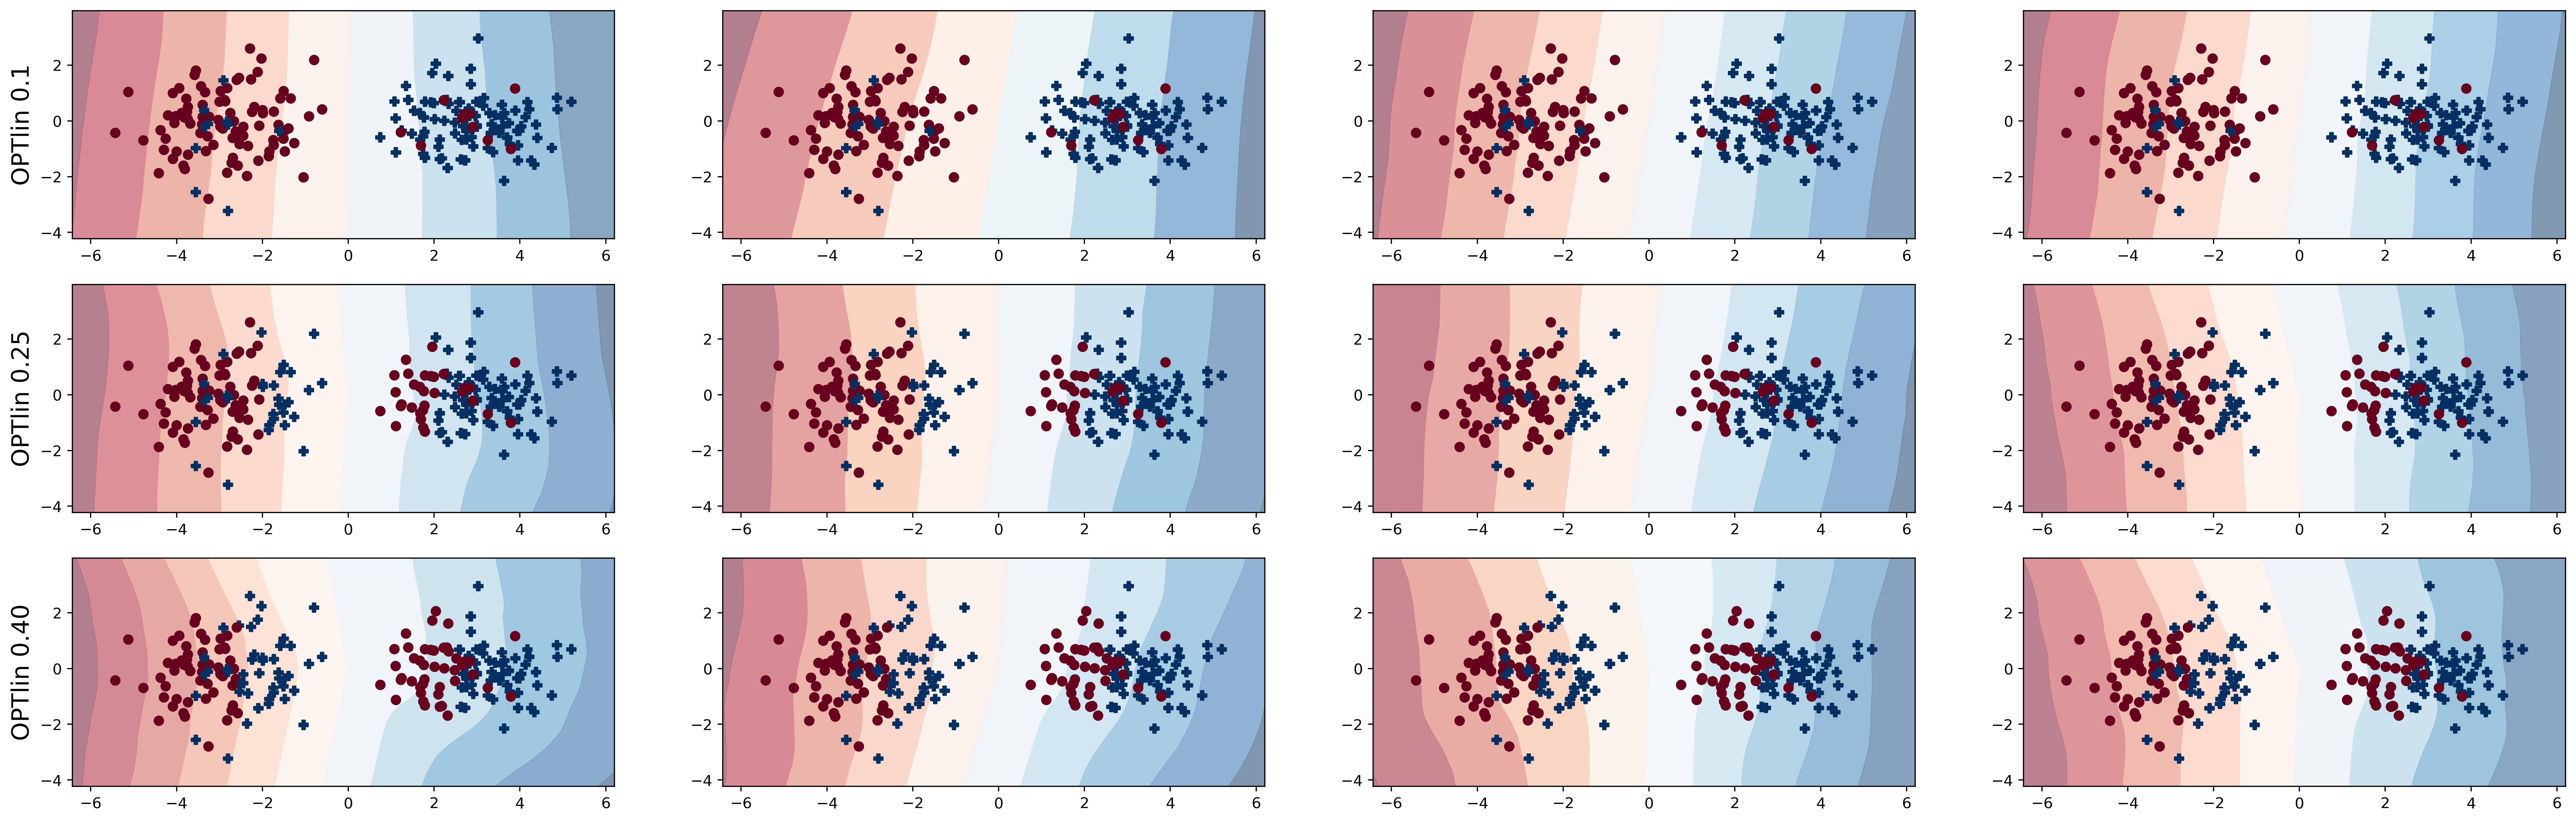

In [10]:
to_plot = 200 # How many samples to plot

# Collect the paths to the .h5 weight files for this experiment
all_files = os.listdir(bp)
experiment_weights = [s for s in all_files if experiment in s]
seeds = [100, 200, 300, 400]

# Set parameters for learner
base_model = one_hlayer_learner(2, # Input dimension
                       width, # Width of network
                       activation = activation, # Either leaky, relu, tanh, sigmoid, elu 
                       init_sd = 1e0, # init doesn't matter as we will be loading weights
                       use_bias_inner = use_bias_inner,
                       use_bias_outer = use_bias_outer,
                       trainable_outer = trainable_outer,
                       seed = 123)

# Prepare figure and set counter for subplots
figure = plt.figure(figsize = (30, 40), dpi = 400)
i = 1
save_figure = True # flag to export figure to pdf into bp dir

# Set colormap
cmap = plt.get_cmap('RdBu')

########################
#   OPTlin = 0.1 first #
########################

optlin = 0.1

# Collect the paths to the .h5 weight files for this OPTlin value.
string1 = 'optlin' + str(optlin) + '_'
paths_optlin = [s for s in experiment_weights if (string1 in s and experiment in s)]

# Prepare a sample dataset to plot for this value of OPTlin.
boundary_factor = b_from_error(optlin, rcn)
data_df, X, y = prep_dataset(to_plot, margin = margin, x_loc = x_loc, rcn = rcn, boundary_factor = boundary_factor)
xmin, xmax = X[:,0].min() - 1, X[:,0].max() + 1
ymin, ymax = X[:,1].min() - 1, X[:,1].max() + 1

# Assign 'o' marker for labels=0, and plus sign marker for labels=1.
markers = ['o' if label == 0 else 'P' for label in y]

# Iterate through the desired four seeds and give contour plots for each seed.
for seed in seeds:
    # Select only those files with the desired seeds
    string2 =  '_seed' + str(seed) + '_'
    paths = [s for s in paths_optlin if string2 in s]

    # Load the model
    model = load_model(base_model, bp + paths[0])
    
    # Prepare subplot consisting of 12 plots across 4 columns
    ax = plt.subplot(12, 4, i)
    
    # Plot and ensure l.h.s. has a label for the value of optlin.
    xx, yy, labels, z = get_predictions(model, xmin, xmax, ymin, ymax, grid_points = 250)
    divnorm = matplotlib.colors.DivergingNorm(vmax = labels.max(), vcenter = 0, vmin = labels.min())
    ax.contourf(xx, yy, z, cmap=cmap, norm = divnorm, levels = 9, alpha=0.5)
    mscatter(X[:,0], X[:,1], c=y.ravel(), m = markers, ax=ax, cmap = cmap)
    if i ==1:
        ax.set_ylabel('OPTlin 0.1', fontsize = 16)
    i += 1
    
# Then repeat the analysis for the remaining two values of OPTlin

########################
#   OPTlin = 0.25 next #
########################

optlin = 0.25

# Collect the paths to the .h5 weight files for this OPTlin value.
string1 = 'optlin' + str(optlin)
paths_optlin = [s for s in experiment_weights if (string1 in s and experiment in s)]

# Prepare a sample dataset to plot for this value of OPTlin.
boundary_factor = b_from_error(optlin, rcn)
data_df, X, y = prep_dataset(to_plot, margin = margin, x_loc = x_loc, rcn = rcn, boundary_factor = boundary_factor)
xmin, xmax = X[:,0].min() - 1, X[:,0].max() + 1
ymin, ymax = X[:,1].min() - 1, X[:,1].max() + 1

# Assign 'o' marker for labels=0, and plus sign marker for labels=1.
markers = ['o' if label == 0 else 'P' for label in y]

# Iterate through the desired four seeds and give contour plots for each seed.
for seed in seeds:
    # Select only those files with the desired seeds
    string2 =  '_seed' + str(seed) + '_'
    paths = [s for s in paths_optlin if string2 in s]

    # Load the model
    model = load_model(base_model, bp + paths[0])
    
    # Prepare subplot consisting of 12 plots across 4 columns
    ax = plt.subplot(12, 4, i)
    
    # Plot and ensure l.h.s. has a label for the value of optlin.
    xx, yy, labels, z = get_predictions(model, xmin, xmax, ymin, ymax, grid_points = 250)
    divnorm = matplotlib.colors.DivergingNorm(vmax = labels.max(), vcenter = 0, vmin = labels.min())
    ax.contourf(xx, yy, z, cmap=cmap, norm = divnorm, levels = 9, alpha=0.5)
    mscatter(X[:,0], X[:,1], c=y.ravel(), m = markers, ax=ax, cmap = cmap)
    if i == 5:
        ax.set_ylabel('OPTlin 0.25', fontsize = 16)
    i += 1
    
########################
#   OPTlin = 0.40 last #
########################

optlin = 0.40

# Collect the paths to the .h5 weight files for this OPTlin value.
string1 = 'optlin' + str(optlin)
paths_optlin = [s for s in experiment_weights if (string1 in s and experiment in s)]

# Prepare a sample dataset to plot for this value of OPTlin.
boundary_factor = b_from_error(optlin, rcn)
data_df, X, y = prep_dataset(to_plot, margin = margin, x_loc = x_loc, rcn = rcn, boundary_factor = boundary_factor)
xmin, xmax = X[:,0].min() - 1, X[:,0].max() + 1
ymin, ymax = X[:,1].min() - 1, X[:,1].max() + 1

# Assign 'o' marker for labels=0, and plus sign marker for labels=1.
markers = ['o' if label == 0 else 'P' for label in y]

# Iterate through the desired four seeds and give contour plots for each seed.
for seed in seeds:
    # Select only those files with the desired seeds
    string2 =  '_seed' + str(seed) + '_'
    paths = [s for s in paths_optlin if string2 in s]

    # Load the model
    model = load_model(base_model, bp + paths[0])
    
    # Prepare subplot consisting of 12 plots across 4 columns
    ax = plt.subplot(12, 4, i)
    
    # Plot and ensure l.h.s. has a label for the value of optlin.
    xx, yy, labels, z = get_predictions(model, xmin, xmax, ymin, ymax, grid_points = 250)
    divnorm = matplotlib.colors.DivergingNorm(vmax = labels.max(), vcenter = 0, vmin = labels.min())
    ax.contourf(xx, yy, z, cmap=cmap, norm = divnorm, levels = 9, alpha=0.5)
    mscatter(X[:,0], X[:,1], c=y.ravel(), m = markers, ax=ax, cmap = cmap)
    if i == 9:
        ax.set_ylabel('OPTlin 0.40', fontsize = 16)
    i += 1
    
if export_figure: 
    figure.savefig(bp + 'decision_boundary.pdf',
                   bbox_inches = 'tight',
                   pad_inches = 0)